In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os

sys.path.insert(0, "/home/aew492/research-summer2020/code")
from suave import cf_model, cosmo_bases
import recover_amps
import generate_mock_list
import globals
globals.initialize_vals()
num_den = globals.lognormal_density

In [2]:
L = 750 #globals.boxsize
num_den = '1e-4' #globals.lognormal_density
As = 2 #globals.As
n_mocks = 401 #globals.n_mocks
grad_type = '1rlz_per_m' #globals.grad_type
print(L, num_den, As, n_mocks, grad_type)

750 1e-4 2 401 1rlz_per_m


### true correlation function

In [3]:
r_t, cf_t_As2x = np.loadtxt(f"/scratch/ksf293/mocks/lognormal/inputs/cat_L{L}_n{num_den}_z057_patchy_As2x_Rh_xi.txt", unpack=True)

In [4]:
r_t, cf_t_As1x = np.loadtxt(f"/scratch/ksf293/mocks/lognormal/inputs/cat_L{L}_n{num_den}_z057_patchy_Rh_xi.txt", unpack=True)

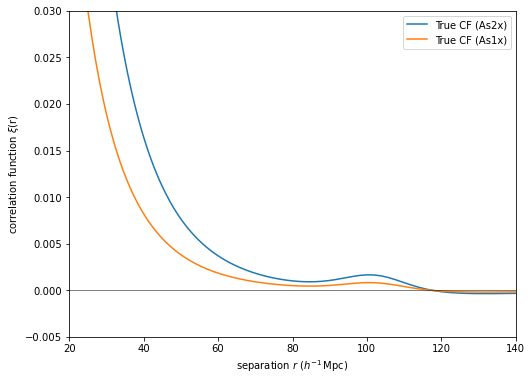

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(r_t, cf_t_As2x, label="True CF (As2x)")
plt.plot(r_t, cf_t_As1x, label="True CF (As1x)")

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
plt.legend()

### basis functions

In [6]:
projfn = 'cosmo_basis.dat'

In [7]:
# redshift 0.0, bias 1.0
bases_0 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.0, bias=1.0)
ncomponents = 4*(bases_0.shape[1]-1)
r_base = bases_0[:,0]
base_vals_z0_b1 = bases_0[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


In [8]:
# redshift 0.57, bias 1.0
bases_1 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.57, bias=1.0)
ncomponents = 4*(bases_1.shape[1]-1)
r_base = bases_1[:,0]
base_vals_z057_b1 = bases_1[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


In [9]:
# redshift 0.0, bias 2.0
bases_2 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.0, bias=2.0)
ncomponents = 4*(bases_2.shape[1]-1)
r_base = bases_2[:,0]
base_vals_z0_b2 = bases_2[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


In [10]:
# redshift 0.57, bias 2.0
bases_3 = cosmo_bases(globals.rmin, globals.rmax, projfn, redshift=0.57, bias=2.0)
ncomponents = 4*(bases_3.shape[1]-1)
r_base = bases_3[:,0]
base_vals_z057_b2 = bases_3[:,1]

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


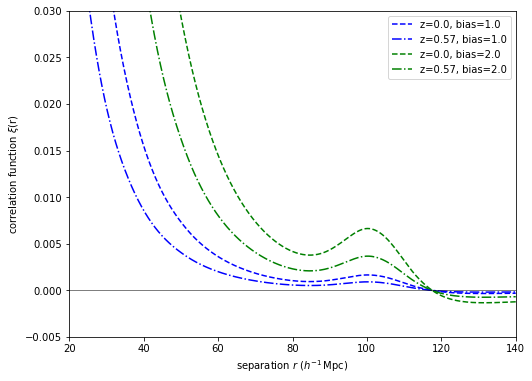

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(r_base, base_vals_z0_b1, color="b", ls="--", label="z=0.0, bias=1.0")
plt.plot(r_base, base_vals_z057_b1, color="b", ls="dashdot", label="z=0.57, bias=1.0")
plt.plot(r_base, base_vals_z0_b2, color="g", ls="--", label="z=0.0, bias=2.0")
plt.plot(r_base, base_vals_z057_b2, color="g", ls="dashdot", label="z=0.57, bias=2.0")

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
plt.legend()

### comparing base vals to true CF

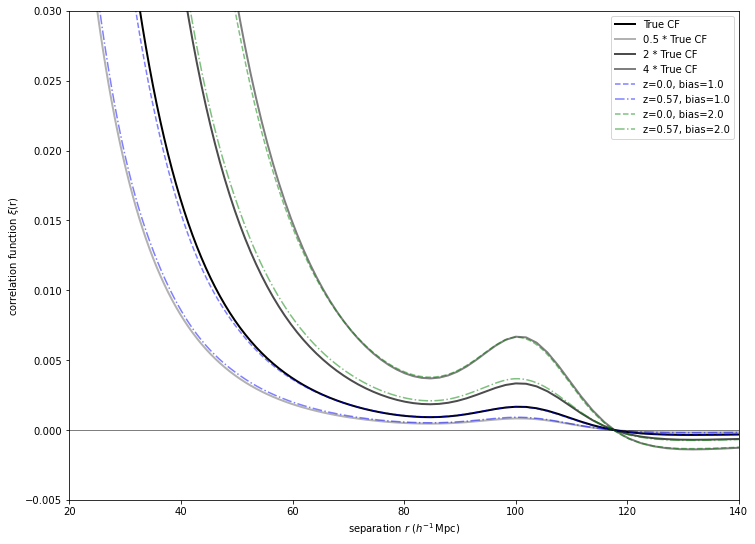

In [12]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_t, cf_t_As2x, color="k", alpha=1, ls="-", lw=2, label="True CF")

plt.plot(r_t, 0.5*cf_t_As2x, color="k", alpha=0.3, ls="-", lw=2, label="0.5 * True CF")
plt.plot(r_t, 2*cf_t_As2x, color="k", alpha=0.7, ls="-", lw=2, label="2 * True CF")
plt.plot(r_t, 4*cf_t_As2x, color="k", alpha=0.5, ls="-", lw=2, label="4 * True CF")

a = 0.5
plt.plot(r_base, base_vals_z0_b1, color="b", ls="--", alpha=a, label="z=0.0, bias=1.0")
plt.plot(r_base, base_vals_z057_b1, color="b", ls="dashdot", alpha=a, label="z=0.57, bias=1.0")
plt.plot(r_base, base_vals_z0_b2, color="g", ls="--", alpha=a, label="z=0.0, bias=2.0")
plt.plot(r_base, base_vals_z057_b2, color="g", ls="dashdot", alpha=a, label="z=0.57, bias=2.0")

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
plt.legend()

In [13]:
# since our True CF is double amplitude (As2x) and redshift z=0.57, it makes sense that
#    2*True CF matches up with base vals z=0.57, bias=2.0

### function: mean xi in each bin + error regions

In [14]:
def get_cfarr_vals(cf_arr):
    arr_len = len(cf_arr[0])
    cfs_mean = np.zeros(arr_len)
    stds = np.zeros(arr_len)
    error_regions = np.empty((arr_len, 2))
    for i in range(arr_len):
        mean, std = np.mean(cf_arr[:,i]), np.std(cf_arr[:,i])
        cfs_mean[i] = mean
        stds[i] = std
        error_regions[i] = [mean-std, mean+std]
    return cfs_mean, stds, error_regions

In [15]:
# new standard binned fit
def f_bases_nograd(r):
    xi_mod = cf_model(r, redshift=0.57, bias=2.0)
    return 2*xi_mod

def fit_to_bases(rlz, r_avg, xi_full_patches):
    X = np.zeros((len(r_avg), 1))
    xi = np.zeros((len(r_avg), 1))
    for nbin in range(len(r_avg)):
        X_bin = f_bases_nograd(r_avg[nbin])
        xi_bin = xi_full_patches[rlz, nbin]
        X[nbin] = X_bin
        xi[nbin] = xi_bin
    C = np.identity(len(xi))
    C_inv = np.linalg.inv(C)
    theta = np.linalg.inv(X.T @ C_inv @ X) @ (X.T @ C_inv @ xi)
    return theta, xi
    # theta basically gives us the best fit amplitude to f_bases

### results from clustered mocks, straight Corrfunc

In [16]:
# mock_vals = generate_mock_list.generate_mock_list(As=1, extra=True)
# mock_file_list = mock_vals['lognorm_file_list']
# xi_arr_nograd = np.empty((len(mock_file_list), globals.nbins)) 
# for i in range(len(mock_file_list)):
#     r_avg, xi = np.load(f'/scratch/aew492/research-summer2020_output/lognormal/xi/{num_den}/xi_{mock_file_list[i]}.npy')
#     xi_arr_nograd[i] = xi

# cfs_mean_nograd, stds_nograd, _ = get_cfarr_vals(xi_arr_nograd)

mock_vals_2x = generate_mock_list.generate_mock_list(boxsize=L,
                                                     lognormal_density=num_den,
                                                     grad_type=grad_type,
                                                     n_mocks=n_mocks,
                                                     As=2, extra=True)
mock_file_list_2x = mock_vals_2x['lognorm_file_list']
xi_arr_nograd_2x = np.empty((len(mock_file_list_2x), globals.nbins)) 
for i in range(len(mock_file_list_2x)):
    r_avg, xi = np.load(f'/scratch/aew492/research-summer2020_output/lognormal/xi/{num_den}/xi_{mock_file_list_2x[i]}.npy')
    xi_arr_nograd_2x[i] = xi

cfs_mean_nograd_2x, stds_nograd_2x, _ = get_cfarr_vals(xi_arr_nograd_2x)

### check xi results against true CF

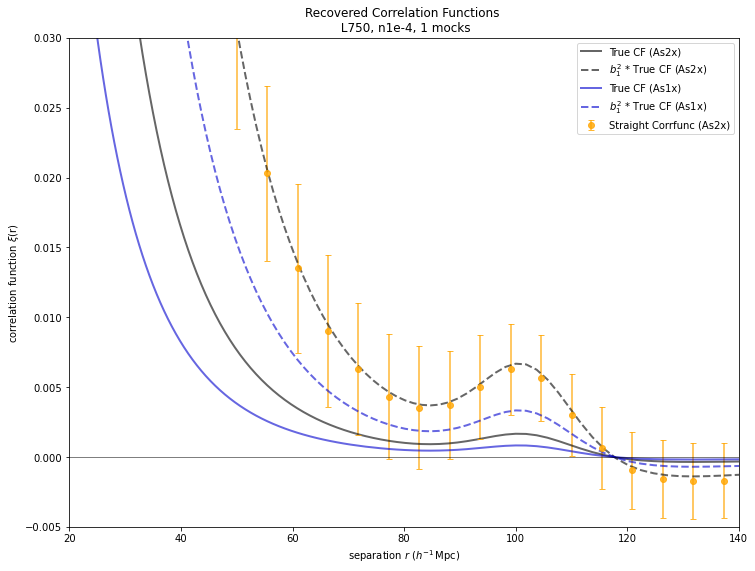

In [17]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_t, cf_t_As2x, color="k", alpha=0.6, ls="-", lw=2, label="True CF (As2x)")
plt.plot(r_t, 4*cf_t_As2x, color="k", alpha=0.6, ls="--", lw=2, label=r"$b_1^2$ * True CF (As2x)")

plt.plot(r_t, cf_t_As1x, color="mediumblue", alpha=0.6, ls="-", lw=2, label="True CF (As1x)")
plt.plot(r_t, 4*cf_t_As1x, color="mediumblue", alpha=0.6, ls="--", lw=2, label=r"$b_1^2$ * True CF (As1x)")

# ax.errorbar(r_avg, cfs_mean_nograd, yerr=stds_nograd, color='r', alpha=0.8, fmt='o', capsize=3, label=f'Straight Corrfunc (As1x)')
ax.errorbar(r_avg, cfs_mean_nograd_2x, yerr=stds_nograd_2x, color='orange', alpha=0.8, fmt='o', capsize=3, label=f'Straight Corrfunc (As2x)')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Recovered Correlation Functions \n L{globals.boxsize}, n{num_den}, {globals.n_mocks} mocks')
plt.legend()

In [18]:
# we can see that for both As1x and As2x, b_1**2 * the true CF, aka 4* the true CF, matches the xi results

### comparing patches and suave results

In [19]:
# recover amplitudes
mock_file_name_list = generate_mock_list.generate_mock_list(boxsize=L,
                                                     lognormal_density=num_den,
                                                     grad_type=grad_type,
                                                     n_mocks=n_mocks,
                                                     As=2)
amps_suave = recover_amps.recover_amps(mock_file_name_list, num_den, method="suave")
amps_patches, xi_full_patches = recover_amps.recover_amps(mock_file_name_list, num_den, method="patches", n_patches=8)
a_0s_s = amps_suave[:,0]

KeyError: 'b_fit'

In [ ]:
# suave
cf_arr_s = np.empty((len(a_0s_s), len(base_vals_z057_b2)))
for i in range(len(a_0s_s)):
    cf_arr_s[i] = a_0s_s[i] * base_vals_z057_b2
        
cfs_mean_s, _, error_regions_s = get_cfarr_vals(cf_arr_s)

In [ ]:
# patches
r_edges = np.linspace(globals.rmin, globals.rmax, globals.nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])

xi_patches = np.array(xi_full_patches)

cfs_mean_p, stds_p, _ = get_cfarr_vals(xi_patches)

In [ ]:
# fit for all 401 mocks
nmocks = globals.n_mocks
thetas = np.zeros(nmocks)
for rlz in range(0, nmocks):
    theta, _ = fit_to_bases(rlz, r_avg, xi_full_patches)
    thetas[rlz] = theta

mean_theta = np.mean(thetas)
std_theta = np.std(thetas)

mean_fit = mean_theta*f_bases_nograd(r_base)
std_fit = std_theta*f_bases_nograd(r_base)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

# b_1^2 * True CF
plt.plot(r_t, 4*cf_t_As2x, color="k", alpha=0.5, ls="--", lw=1.5, zorder=100, label=r"$b_1^2$ * True CF (As2x)")
plt.plot(r_t, 4*cf_t_As1x, color="k", alpha=0.8, ls="--", lw=2, zorder=100, label=r"$b_1^2$ * True CF (As1x)")

# # "old" method
# # patches
# ax.errorbar(r_avg, cfs_mean_p, yerr=stds_p, color='b', alpha=0.8, fmt='o', capsize=3, label=f'recovered xi')
#     # does not rely on cf_model() because we're only taking xi_full

# new standard binned fit
plt.plot(r_base, mean_fit, color="b", lw=2, label="new standard binned fit")
ax.fill_between(r_base, mean_fit+std_fit, mean_fit-std_fit, color="b", alpha=0.2)

# suave
ax.plot(r_base, cfs_mean_s, color='g', label=f'suave: $a_0 * $ BAO base')
ax.fill_between(r_base, error_regions_s[:,0], error_regions_s[:,1], color='green', alpha=0.2)
    # does rely on cf_model because we're taking the fitted amplitudes

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.03)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Recovered Correlation Functions \n m=0, L{globals.boxsize}, n{num_den}, {globals.n_mocks} mocks, As{globals.As}x')
plt.legend()

In [ ]:
# i think this makes sense– this is for mocks As2x but since m=0 b=0.5, we effectively half the amplitude when
#    we run the clustered mocks through the gradient generating script. this is why both the suave and 'patches'
#    results line up with the As1x True CF * bias multiplier